# Machine Learning: Getting Density for SAFT-$\gamma$ Mie and Beyond

Now let's turn to predicting density with ANN or other machine learning techniques, trying in parallel development to use 1) SAFT-$\gamma$ Mie parameters, 2) experimental data and loading from API and 3) potentially using atomistic model / forcefield. Here, we will consider using SMILES to read atomistic data as well.

## SAFT-$\gamma$ Mie

In [1]:
import saftgmie as saft
import numpy as np
import pandas as pd
import math
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm
from sklearn import gaussian_process
import scipy
from scipy.optimize import fsolve, least_squares, leastsq

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from sklearn import preprocessing

For each case, the key difference in predicting with machine learning algorithm is the input parameters, i.e. how do we represent the molecules when predicting it. So for some typical examples used in previous papers include using molecular weight to predict boiling point, or reduced temperature to predict Boyle temperature etc. For each individual case, we have to be sure of what we are predicting and what we are predicting it with.

For the SAFT-$\gamma$ Mie case, we are predicting the result of molecular simulation and not the physical properties of real fluid per se. There is a difference here that essentially allows me to fit parameters based on the predicted physical properties (i.e. according to experimental data regression of viscosity, these SAFT-$\gamma$ Mie parameters best represent this molecule) which could lead to using different parameterisation for different molecular simulation purposes.

Fitting experimental data is different in the way that we are removing this molecular simulation bridge, essentially using whatever input parameters as the best description available for the molecules. Hence, we can predict the actual fluid properties if we can accurately describe the molecules in the way that we want.

Atomistic model may be more comprehensive that the SAFT-$\gamma$ Mie case, but it is still a matter of fitting simulation data as output, which really depends on the forcefield we are using. To make this into an actual predictive algorithm, what we really need some form of correction towards experimental data. Do take note of any presence of biases towards certain type of molecules (e.g. there are more available info about alkanes as compared to ether)

### Preparing and preprocessing of data

In [158]:
# Reading data (if we have already generated)
inputfile = 'saftgmie_vle_data_trimmed.csv'
df = pd.read_csv(inputfile)

ms_inputs = df.iloc[:,0].values
rep_inputs = df.iloc[:,1].values
temp_inputs = df.iloc[:,2].values
pv_outputs = df.iloc[:,3].values
rhol_outputs = df.iloc[:,4].values
rhov_outputs = df.iloc[:,5].values

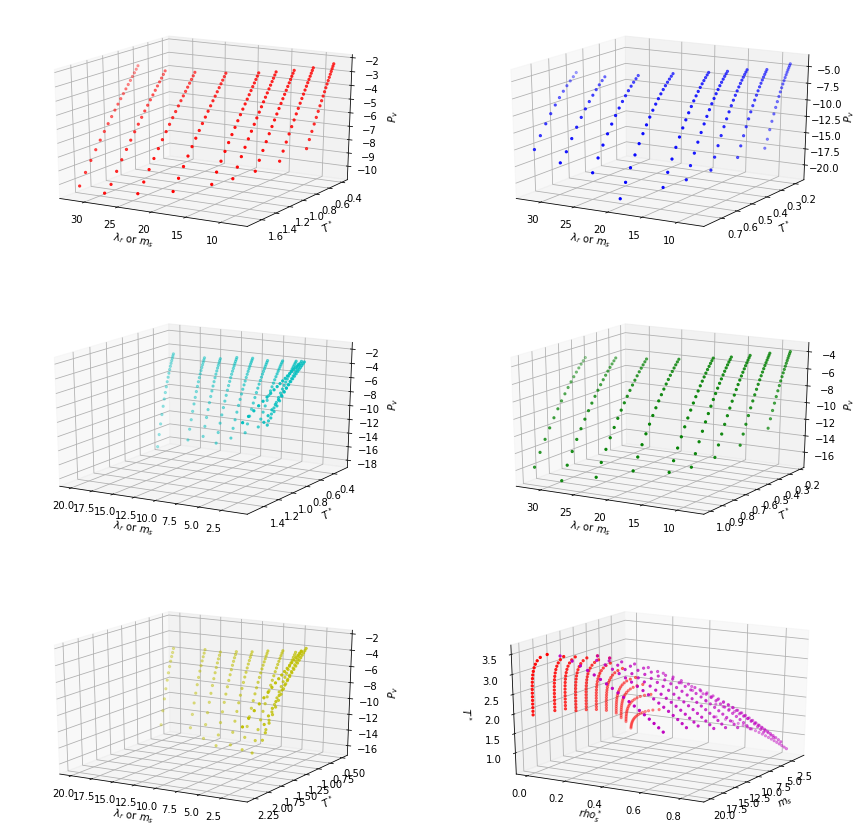

In [159]:
ms2_only = df.loc[df.iloc[:,0] == 2.0]
ms20_only = df.loc[df.iloc[:,0] == 20.0]
rep12_only = df.loc[df.iloc[:,1] == 12.0]
ms10_only = df.loc[df.iloc[:,0] == 10.0]
rep32_only = df.loc[df.iloc[:,1] == 32.0]
rep28_only = df.loc[df.iloc[:,1] == 28.0]

fig = plt.figure(figsize=(15,15))
ax = []
all_x = [ms2_only.iloc[:,1].values,
         ms20_only.iloc[:,1].values,
         rep12_only.iloc[:,0].values,
         ms10_only.iloc[:,1].values,
         rep32_only.iloc[:,0].values,
         rep28_only.iloc[:,0].values]
all_y = [ms2_only.iloc[:,2].values,
         ms20_only.iloc[:,2].values,
         rep12_only.iloc[:,2].values,
         ms10_only.iloc[:,2].values,
         rep32_only.iloc[:,2].values,
         rep28_only.iloc[:,2].values]

all_z = [ms2_only.iloc[:,3].values,
         ms20_only.iloc[:,3].values,
         rep12_only.iloc[:,3].values,
         ms10_only.iloc[:,3].values,
         rep32_only.iloc[:,3].values,
         rep28_only.iloc[:,3].values]
c = list('rbcgym')
for i in range(5):
    ax.append(fig.add_subplot(321+i, projection="3d"))
    ax[i].scatter(all_x[i], 1/all_y[i], np.log(all_z[i]), c=c[i], marker='.')
    ax[i].set_xlabel('$\lambda_r$ or $m_s$')
    ax[i].set_ylabel('$T^*$')
    ax[i].set_zlabel('$P_v$')
    ax[i].view_init(20,120)

ax.append(fig.add_subplot(326, projection="3d"))
ax[5].scatter(all_x[2], rep12_only.iloc[:,4].values*all_x[2], all_y[2], c=c[5], marker='.')
ax[5].scatter(all_x[2], rep12_only.iloc[:,5].values*all_x[2], all_y[2], c=c[0], marker='.')
ax[5].set_xlabel('$m_s$')
ax[5].set_zlabel('$T^*$')
ax[5].set_ylabel('$rho_s^*$')
ax[5].view_init(20,30)

# df2 = pd.DataFrame(np.column_stack([all_x[2], rep12_only.iloc[:,4].values*all_x[2], rep12_only.iloc[:,5].values*all_x[2], all_y[2]]))
# df3 = pd.DataFrame(np.column_stack([all_x[0], all_y[0], all_z[0]]))

# df2.to_csv("vle-trho.csv", index=False, header=False)
# df3.to_csv("vle-tpv.csv", index=False, header=False)


In [32]:
# Setting up basic deep learning class
class SimpleNet(nn.Module):
    def __init__(self, input_output, layers, activation_func=None):
        super().__init__()
        input_dim = input_output[0]
        output_dim = input_output[1]
        self.beta = nn.ModuleList()
        self.sig = nn.ModuleList() if activation_func is not None else None
        while (activation_func is not None) and len(activation_func) < len(layers):
            activation_func.append(activation_func[-1])
            
        for i in range(len(layers)):
            if i == 0:
                self.beta.append(nn.Linear(input_dim, layers[i]))

            if i < len(layers)-1:
                self.beta.append(nn.Linear(layers[i], layers[i+1]))
                if self.sig is not None:
                    self.sig.append(activation_func[i])
                
            else:
                self.beta.append(nn.Linear(layers[i],output_dim))
        self.layers = len(self.beta)

    def forward(self, x):
        for i in range(self.layers):
            f = self.beta[i]
            if i == 0 or i == self.layers - 1 or self.sig is None:
                x = f(x)
            else:
                a = self.sig[i-1]
                x = a(f(x))
        return x

In [176]:
x_scaler = preprocessing.StandardScaler()
x_train = x_scaler.fit_transform(np.column_stack([ms_inputs, rep_inputs, 1/temp_inputs]))
y_scaler = preprocessing.StandardScaler()
y_train = y_scaler.fit_transform(np.column_stack([np.log(pv_outputs)]))

x = torch.from_numpy(x_train).float()
y = torch.from_numpy(y_train).float()
xv = torch.from_numpy(x_train).float()
yv = torch.from_numpy(y_train).float()

model_vle = SimpleNet((3,1), [50,30, 10], [nn.Tanh(), nn.Tanh(), nn.ReLU()])
optimizer = optim.Adam(model_vle.parameters())#, lr=0.01)
criterion = nn.MSELoss()
epochs = 0

Text(0.5,0.92,'MSE: 0.00013, Epochs: 6000')

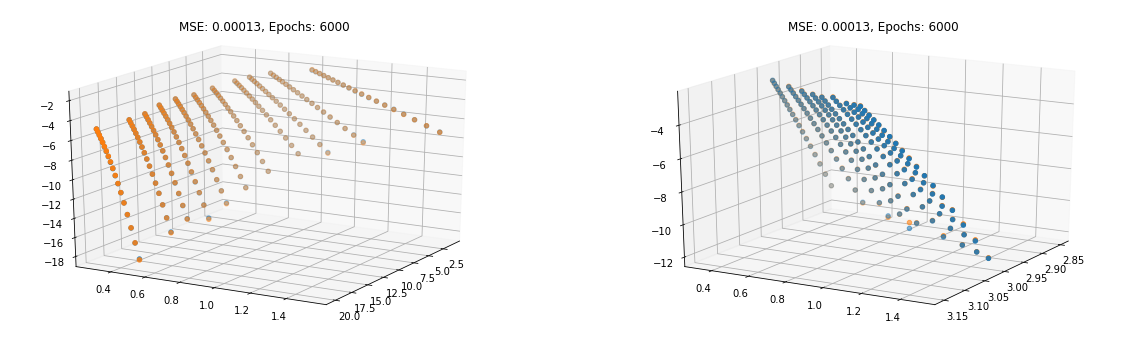

In [182]:
for i in range(1000):
    model_vle.train()
    optimizer.zero_grad()

    y_ = model_vle(x)
    loss = criterion(y_, y)

    # print('epoch: ', epoch,' loss: ', loss.item())
    loss.backward()
    optimizer.step()
    epochs += 1

model_vle.eval()
with torch.no_grad():
    yv_ = model_vle(xv)
    loss = criterion(yv_, yv)

fig = plt.figure(figsize=(20,6))

ax1 = fig.add_subplot(121, projection='3d')
yres_ = y_scaler.inverse_transform(yv_.numpy())
yres = y_scaler.inverse_transform(yv.numpy())
ax1.scatter(ms_inputs[(rep_inputs == 12.0)], 1/temp_inputs[(rep_inputs == 12.0)], yres_[(rep_inputs == 12.0),0], '.', label='pred')
ax1.scatter(ms_inputs[(rep_inputs == 12.0)], 1/temp_inputs[(rep_inputs == 12.0)], yres[(rep_inputs == 12.0),0], '.', label='data')
ax1.view_init(20,30)
ax1.set_title(f"MSE: {loss.item():0.5f}, Epochs: {epochs:d}")

ax1 = fig.add_subplot(122, projection='3d')
yres_ = y_scaler.inverse_transform(yv_.numpy())
yres = y_scaler.inverse_transform(yv.numpy())
ax1.scatter(ms_inputs[(ms_inputs == 3.0)], 1/temp_inputs[(ms_inputs == 3.0)], yres_[(ms_inputs == 3.0),0], '.', label='pred')
ax1.scatter(ms_inputs[(ms_inputs == 3.0)], 1/temp_inputs[(ms_inputs == 3.0)], yres[(ms_inputs == 3.0),0], '.', label='data')
ax1.view_init(20,30)
ax1.set_title(f"MSE: {loss.item():0.5f}, Epochs: {epochs:d}")


# ax2 = fig.add_subplot(122, projection='3d')
# ax2.scatter(ms_inputs[(rep_inputs == 12.0)], temp_inputs[(rep_inputs == 12.0)], yres_[(rep_inputs == 12.0),1] * ms_inputs[(rep_inputs == 12.0)], 'b.', label='pred')
# ax2.scatter(ms_inputs[(rep_inputs == 12.0)], temp_inputs[(rep_inputs == 12.0)], yres[(rep_inputs == 12.0),1]* ms_inputs[(rep_inputs == 12.0)], 'r.', label='data')
# ax2.scatter(ms_inputs[(rep_inputs == 12.0)], temp_inputs[(rep_inputs == 12.0)], yres_[(rep_inputs == 12.0),2]*ms_inputs[(rep_inputs == 12.0)], 'k.', label='pred')
# ax2.scatter(ms_inputs[(rep_inputs == 12.0)], temp_inputs[(rep_inputs == 12.0)], yres[(rep_inputs == 12.0),2]*ms_inputs[(rep_inputs == 12.0)], 'g.', label='data')

# ax2.view_init(20,300)
# ax1.set_title(f"MSE: {loss.item():0.5f}, Epochs: {epochs:d}")

In [143]:
kb = 1.38064852e-23
nmtom = 1e-9
avo = 6.02214086e23

# ms, lam, sig, epsi, pcrit, tcrit, rhocrit
prop = np.array((1, 34.29, 0.4871, 426.08, 376.20, 4.77, 219.98, 0.04410))
nhex = np.array((2, 19.57, 0.4508, 376.35, 515.29, 3.44, 241.16, 0.08618))
noct = np.array((3, 16.14, 0.4227, 333.70, 576.72, 2.77, 227.83, 0.11423))
ndec = np.array((3, 20.92, 0.4584, 415.19, 626.37, 2.31, 219.85, 0.14229))

check_data = np.vstack([prop, nhex, noct, ndec])
check_data[:,4] = check_data[:,4] / check_data[:,3]
check_data[:,5] = check_data[:,5] * 1e6 * (check_data[:,2] * nmtom)**3 / (check_data[:,3] * kb)
check_data[:,6] = check_data[:,6] * check_data[:,0] / check_data[:,7] * avo * (check_data[:,2] * nmtom)**3

# check_x = torch.from_numpy(x_scaler.transform(check_data[:,0:2])).float()
# check_y = np.column_stack([check_data[:,5],check_data[:,4],check_data[:,6]])


ms_in = np.array([])
rep_in = np.array([])
t_in = np.array([])
pv_out = np.array([])

start_time = time.time()

for ms,rep,sig,epsi,tc in check_data[:,0:5]:
    gt = saft.GroupType(rep, 6., sig, epsi, shape_factor=1)
    cm = saft.Component(10.).quick_set((gt, int(ms))) 
    pure_sys = saft.System().quick_set((cm, 1000))
    t_crit = tc
    
    tpoints = 20
    temp_range = epsi * np.linspace(t_crit*0.5, t_crit*0.995, tpoints)

    for j in range(tpoints):
        t = temp_range[j]
        vle = (-1,-1)
        try:
            if j == 0 or vle[0] == -1:
                ig = (1 * ms *(sig * nmtom)**3 * avo, 100*ms*(sig * nmtom)**3 * avo)
            else:
                ig = vle
            pv, vle = pure_sys.vapour_pressure(t, initial_guess=ig, get_volume=True, print_results=False)
            if abs(vle[0] - vle[1]) < 1e-6:
                print()
                print(f'VLE points solver failed to converge at meaningful results at T={t:5.2f}, points too similar ({vle[0]:7.3e}, {vle[1]:7.3e})')
                vle = ig
            else:
                ms_in = np.append(ms_in, ms)
                rep_in = np.append(rep_in, rep)
                t_in = np.append(t_in, t/epsi)
                pv_out = np.append(pv_out, pv * (sig * nmtom)**3 / (epsi * kb))
        except:
            print()
            print('VLE solver failed at T={t:5.2f} due to out of range operations. Current point aborted.')
            
        elapsed_time = time.time() - start_time
        print(f'VLE data generation at {int((j+1)*100/tpoints):3d}% complete, time elapsed: {elapsed_time:5.2f} s, vle (ms={ms:3.1f},rep={rep:3.1f}) results ({vle[0]:7.3e}, {vle[1]:7.3e})', end='\r')
    print(f'Data generation complete for pure system (ms={ms:3.1f},rep={rep:3.1f})', ' '*40)


  1 groups were to be added,   1 groups were added
VLE data generation at  85% complete, time elapsed: 50.32 s, vle (ms=1.0,rep=34.3) results (1.132e-04, 6.256e-04)
VLE points solver failed to converge at meaningful results at T=354.72, points too similar (3.225e-04, 3.226e-04)
VLE data generation at  95% complete, time elapsed: 69.66 s, vle (ms=1.0,rep=34.3) results (1.410e-04, 3.392e-04)
VLE points solver failed to converge at meaningful results at T=374.32, points too similar (9.365e-04, 9.365e-04)
Data generation complete for pure system (ms=1.0,rep=34.3)                                         05, 6.960e-03)
  2 groups were to be added,   2 groups were added
VLE data generation at  90% complete, time elapsed: 133.25 s, vle (ms=2.0,rep=19.6) results (2.229e-04, 8.089e-04)
VLE points solver failed to converge at meaningful results at T=499.29, points too similar (6.637e-04, 6.637e-04)
VLE data generation at  95% complete, time elapsed: 138.08 s, vle (ms=2.0,rep=19.6) results (1.103e

           0         1         2
0   0.684589  0.000056  0.000004
1   0.720259  0.000121  0.000008
2   0.755930  0.000239  0.000021
3   0.791601  0.000440  0.000056
4   0.827272  0.000760  0.000133
5   0.862942  0.001245  0.000287
6   0.898613  0.001946  0.000565
7   0.934284  0.002922  0.001040
8   0.969954  0.004238  0.001808
9   1.005625  0.005966  0.002976
10  1.041296  0.008180  0.004648
11  1.076966  0.010964  0.006917
12  1.112637  0.014407  0.009872
13  1.148308  0.018611  0.013605
14  1.183978  0.023691  0.018199
15  1.219649  0.029789  0.023702
16  1.255320  0.037092  0.030090
17  1.290990  0.045869  0.037255


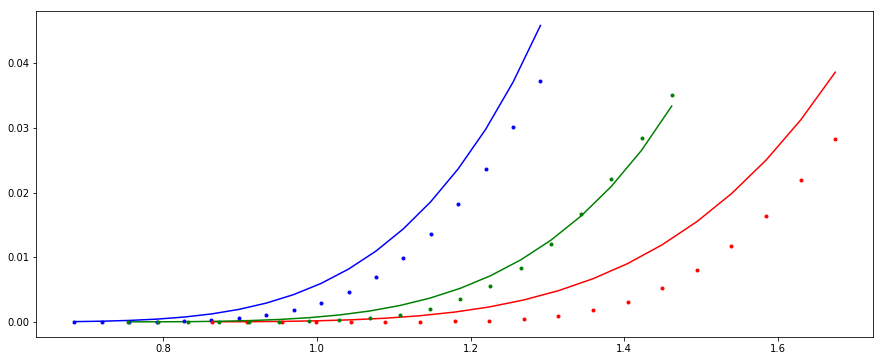

In [173]:
fig, ax = plt.subplots(1,1,figsize=(15,6))
c = list('rbcgym')

# ax.plot(t_in[(ms_in == 1)], (pv_out[(ms_in == 1)]), c[0])
ax.plot(t_in[(ms_in == 2)], (pv_out[(ms_in == 2)]), c[1])
ax.plot(t_in[(rep_in < 17)], (pv_out[(rep_in < 17)]), c[0])
ax.plot(t_in[(rep_in == 20.92)], (pv_out[(rep_in == 20.92)]), c[3])

# ax.plot(t_in[(ms_in == 1)], np.exp(pv_[(ms_in == 1)]), c[0]+'.', linestyle="None")
ax.plot(t_in[(ms_in == 2)], np.exp(pv_[(ms_in == 2)]), c[1]+'.', linestyle="None")
ax.plot(t_in[(rep_in < 17)], np.exp(pv_[(rep_in < 17)]), c[0]+'.', linestyle="None")
ax.plot(t_in[(rep_in == 20.92)],np.exp(pv_[(rep_in == 20.92)]), c[3]+'.', linestyle="None")

dft = pd.DataFrame(np.column_stack([t_in[(ms_in == 2)], pv_out[(ms_in == 2)], np.exp(pv_[(ms_in == 2)])]))
dft2 = pd.DataFrame(np.column_stack([t_in[(rep_in < 17)], pv_out[(rep_in < 17)], np.exp(pv_[(rep_in < 17)])]))
dft3 = pd.DataFrame(np.column_stack([t_in[(rep_in == 20.92)], pv_out[(rep_in == 20.92)], np.exp(pv_[(rep_in == 20.92)])]))
print(dft)

dft.to_csv("n-hex.csv", index=False, header=False)
dft2.to_csv("n-oct.csv", index=False, header=False)
dft3.to_csv("n-dec.csv", index=False, header=False)


In [165]:
tocheck = np.column_stack([ms_in, rep_in, 1/t_in])

x_tocheck = x_scaler.fit_transform(tocheck)
y_tocheck = y_scaler.fit_transform(np.column_stack([np.log(pv_out)]))
xvv = torch.from_numpy(x_tocheck).float()
yvv = torch.from_numpy(y_tocheck).float()
model_vle.eval()
with torch.no_grad():
    yout_ = model_vle(xvv)
    loss = criterion(yout_, yvv)

pv_ = y_scaler.inverse_transform(yout_.numpy())

print(loss.item(), np.shape(pv_), np.shape(x_tocheck))

2.1068999767303467 (74, 1) (74, 3)


In [ ]:
# Gaussian Process Regression
kern = .1 * gaussian_process.kernels.Matern(length_scale=1) + gaussian_process.kernels.WhiteKernel()
gpr = gaussian_process.GaussianProcessRegressor(kernel=kern).fit(x_train, y_train)

test_ms = np.repeat(np.linspace(1,20,200), 200)
test_rep = np.tile(np.linspace(8,32,200), 200)
test_inputs = np.column_stack([test_ms, test_rep])

fitted_c = gpr.predict(x_scaler.transform(test_inputs), return_std=False) # outputs (y, std) if std=True

fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(ms_data, rep_data, pc_data, '.', label='pred')
ax.plot_surface(test_ms.reshape(200,200), test_rep.reshape(200,200),
                y_scaler.inverse_transform(fitted_c)[:,0].reshape(200,200), rstride=1, cstride=1,
                cmap='spring', edgecolor='none', label='data')
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel('$m_s$',fontsize=16,labelpad=10)
ax.set_ylabel('$\lambda$',fontsize=16,labelpad=10)
ax.set_zlabel('$P_c^*$',fontsize=16,labelpad=10)

# fig.savefig('pcrit_gpr.png', bbox_inches="tight", dpi=600, transparent=True, pad_inches=0)


## Experimental Data Fitting

In [27]:
inputfile = 'saftgmie_vle_data_editted.xlsx'
dfx = pd.read_excel(inputfile)
dfx.to_csv('saftgmie_vle_data_trimmed.csv', index=False)

## Atomistic Proof of Concept